In [62]:
import pickle
import pandas as pd
import numpy as np
import os
from keras.preprocessing import image, sequence

In [63]:
from keras.preprocessing import image,sequence
from keras.applications import InceptionV3
from keras.layers import Dense,Convolution2D,Embedding,Dropout,LSTM,TimeDistributed,Bidirectional,Activation,RepeatVector,Merge,concatenate,Flatten
from keras.optimizers import Adam, RMSprop,Nadam
from keras.models import Sequential, Model
import nltk
import glob
from PIL import Image
%matplotlib inline
import pickle
from tqdm import tqdm

In [64]:
images_dir = os.listdir("./Flickr8k_Dataset/Flicker8k_Dataset/")

images_path = './Flickr8k_Dataset/Flicker8k_Dataset/'
captions_path = './Flickr8k_text/Flickr8k.token.txt'
train_path = './Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = './Flickr8k_text/Flickr_8k.devImages.txt'

In [65]:
captions = open(captions_path,'r').read().strip().split('\n')
x_train = open(train_path,'r').read().strip().split('\n')
x_val = open(val_path,'r').read().strip().split('\n')

In [66]:
pd_dataset_train= pd.read_csv("./Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
pd_dataset_val= pd.read_csv("./Flickr8k_text/flickr_8k_val_dataset.txt", delimiter='\t')
dict_tokens = pickle.load(open("dict_tokens.p","rb"))
encoding_train = pickle.load(open('train_encoded_images.p', 'rb'))
encoding_test = pickle.load(open('val_encoded_images.p', 'rb'))

In [67]:

images = 'Flickr8k_Dataset/Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [68]:

test_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [69]:
test_img = split_data(test_images)
len(test_img)

1000

In [70]:
pd_dataset_train.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [71]:
pd_train = pd_dataset_train.values
pd_train.shape

(30000, 2)

In [72]:
captions = []
for i in range(pd_train.shape[0]):
    captions.append(pd_train[i,1])

In [73]:
split_caption = [word.split() for word in captions ]

In [74]:
unique_words = []
for i in split_caption:
    unique_words.extend(i)

In [75]:
unique = list(set(unique_words))
vocab_size = len(unique)
vocab_size

8253

In [76]:
word2index = { val:index for index,val in enumerate(unique) }
index2word = { index:val for index,val in enumerate(unique) }

In [77]:
np.save("word_2_index.npy",word2index)
np.save("index_2_word.npy",index2word)

In [78]:
word2index

{'conversing': 0,
 'three-wheeled': 1,
 'mishap': 2,
 'fitls': 3,
 'finds': 4,
 'skaters': 5,
 'graffti': 6,
 'shaded': 7,
 'bowled': 8,
 'collecting': 9,
 'League': 10,
 'cuts': 11,
 'puppet': 12,
 'Of': 13,
 'pet': 14,
 'confetti': 15,
 'person': 16,
 'Police': 17,
 'rates': 18,
 'backpacker': 19,
 'fuchsia': 20,
 'doggy': 21,
 'white': 22,
 'belt': 23,
 'attaches': 24,
 'times': 25,
 'rod': 26,
 'event': 27,
 'Third': 28,
 'cutoff': 29,
 'musical': 30,
 'bedspread': 31,
 'drawn': 32,
 'kicked': 33,
 'stirring': 34,
 'parking': 35,
 'headband': 36,
 'warily': 37,
 'bumpy': 38,
 'patiently': 39,
 'leaping': 40,
 'cave': 41,
 'computers': 42,
 'screening': 43,
 'beaver': 44,
 'faces': 45,
 'pinches': 46,
 'professionally': 47,
 'latter': 48,
 'litttle': 49,
 'star-shaped': 50,
 'TV': 51,
 'snow': 52,
 'beat-up': 53,
 'atop': 54,
 'photograhi': 55,
 'squeezing': 56,
 'mp3': 57,
 'navigates': 58,
 'straddle': 59,
 'heart': 60,
 'band': 61,
 'effort': 62,
 'rapidly': 63,
 'western': 64,
 

In [79]:
max_len = 0
for i in captions:
    sent = i.split()
    if len(sent)>max_len:
        max_len = len(sent)
print(max_len,i)

40 <start> The girl in the bathing suit is poised in midair next to the blue water . <end>


## Generator
We will use the encoding of an image and use a start word to predict the next word. After that, we will again use the same image and use the predicted word to predict the next word. So, the image will be used at every iteration for the entire caption. This is how we will generate the caption for an image. Hence, we need to create a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully. Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

ref->>>

https://github.com/yashk2810/Image-Captioning/blob/master/Image%20Captioning%20InceptionV3.ipynb


In [80]:

def data_generator(batch_size = 32):
        pd_dataset_train= pd.read_csv("./Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
        partial_caps = []
        next_words = []
        images = []
        
        df = pd_dataset_train
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2index[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2index[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0


In [81]:
embedding_size = 128

In [82]:
image_model = Sequential()
image_model.add(Dense(embedding_size,input_shape =(2048,),activation='relu' ))
image_model.add(RepeatVector(max_len))
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [83]:
language_model = Sequential()
language_model.add(Embedding(input_dim = vocab_size,output_dim=embedding_size,input_length=max_len))
language_model.add(LSTM(256,return_sequences=True))
language_model.add(TimeDistributed(Dense(300)))
language_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 128)           1056384   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 300)           77100     
Total params: 1,527,724
Trainable params: 1,527,724
Non-trainable params: 0
_________________________________________________________________


In [84]:
model = Sequential()
model.add(Merge([image_model,language_model],mode = 'concat',concat_axis=-1))
model.add(LSTM(256,return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.summary()

/home/meghanshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 40, 428)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               701440    
_________________________________________________________________
dense_6 (Dense)              (None, 8253)              2121021   
_________________________________________________________________
activation_2 (Activation)    (None, 8253)              0         
Total params: 4,612,457
Trainable params: 4,612,457
Non-trainable params: 0
_________________________________________________________________


In [91]:
samples_per_epoch =130000

In [92]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1,verbose=1)

/home/meghanshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/home/meghanshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=130000, epochs=1)`
  """Entry point for launching an IPython kernel.


Epoch 1/1
130000/130000 [==============================] - 17941s 138ms/step - loss: 5.9537 - acc: 0.0780


In [93]:
model.save_weights("f1.h5")

In [22]:
model.load_weights("f1.h5")

In [1]:
##----train----##

In [94]:

def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2index[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = index2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

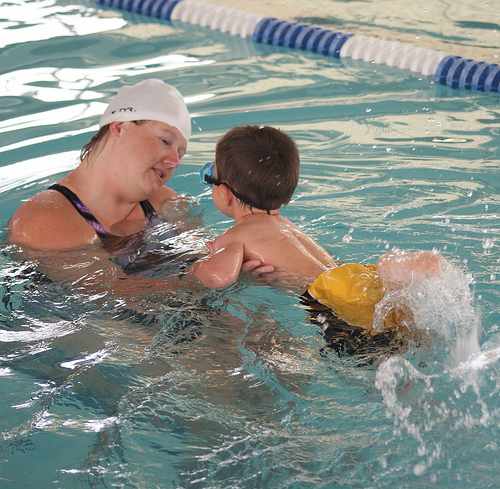

In [95]:

try_image = test_img[0]
Image.open(try_image)

In [ ]:
print ('Normal Max search:', predict_captions(try_image)) 